# Fetch Rewards Data Analyst Assesment


In this notebook, I arranged reciepts.json, brands.json and users.json files into tabular dataframe. After thorough analysis, I've identified few data quality issues that is worth consulting with business stakeholders. In addition, I've also analyzed "  average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’" using T-SQL. Please refer to the scripts below. 

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Receipts Schema


In [4]:
# parse receipts file to dataframe
receipts = pd.read_json('receipts.json', lines=True)
#display(receipts)

In [5]:
# extract the obejct ID from the _id column
receipts['_id'] = receipts['_id'].apply(lambda x: x['$oid'])

#function to change the unix Epoch milliseconds time to datetime
def convert_datetime(df, col):
  ans=[]
  for x in df[col].values:
    if type(x) == float:
      ans.append(np.nan)
    else:
      # assuming the datetime is in milliseconds
      ans.append(pd.to_datetime(datetime.fromtimestamp(x['$date'] // 1000)))
  df[col] = ans
  return df

# list of columns with date
date_cols = ['createDate', 'dateScanned', 'finishedDate',
             'modifyDate', 'pointsAwardedDate', 'purchaseDate']

# loop over the datetime columns
for col in date_cols:
  receipts = convert_datetime(receipts, col)

In [8]:
#extract the Receipt Item lists table from Receipts
# generate the items table by examing the rewardsReceiptItemList in receipts data
item = pd.DataFrame()
item['oid'] = ''
id=[]

for i in range(len(receipts['rewardsReceiptItemList'])):
  x = receipts['rewardsReceiptItemList'].iloc[i]
  if type(x) != float:
    for y in x:
      item = pd.concat([item, pd.DataFrame.from_dict(y, orient='index').transpose()])
      item['oid'] = item['oid'].fillna(receipts.iloc[i]['_id'])

In [11]:
#display(item)

# Users Schema


In [12]:
# Parse users file
users = pd.read_json('users.json', lines=True)

# extract the id from the object
users['_id'] = users['_id'].apply(lambda x: x['$oid'])

# Format the date columns
date_cols = ['createdDate', 'lastLogin']
for col in date_cols:
  users = convert_datetime(users, col)

In [13]:
display(users)

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 09:25:30,2021-01-03 09:25:30,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 08:21:22,2021-03-05 10:52:23,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 08:21:22,2021-03-05 10:52:23,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 08:21:22,2021-03-05 10:52:23,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 08:21:22,2021-03-05 10:52:23,fetch-staff,NaN,NaN


# BRANDS SCHEMA

In [15]:
#parse brands file
brands = pd.read_json('brands.json', lines=True)

# extract Id from the object ID
brands['_id'] = brands['_id'].apply(lambda x: x['$oid'])

In [16]:
#extrancting oid and ref from cpg column
cpg = pd.DataFrame()
id=[]
oid=[]
ref=[]

for i in range(len(brands['cpg'])):
  x = brands['cpg'].iloc[i]
  if type(x) != float:
      oid.append(brands['cpg'][i]['$id']['$oid'])
      ref.append(brands['cpg'][i]['$ref'])
      id.append(brands.iloc[i]['_id'])

cpg['id'] = id
cpg['oid'] = oid
cpg['ref'] = ref

#merging it back to brands dataframe
brands = brands.merge(cpg, left_on='_id', right_on='id', how='left').drop('id', axis=1)


In [19]:
#display(brands)

# Data Quality Exploration and Evaluation

Here I examined the missing values and distribution of rewards points.

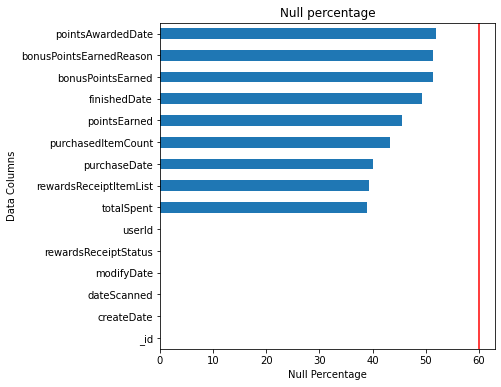

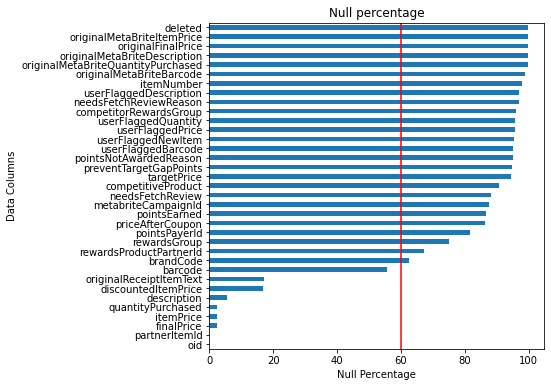

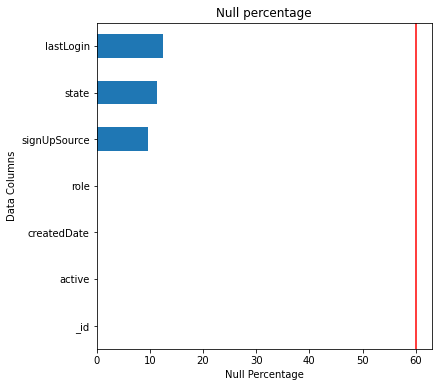

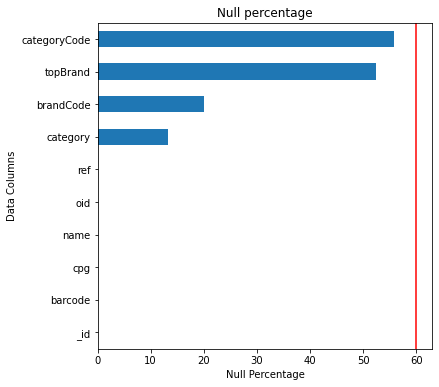

In [21]:
# function for perctange of missing values
def get_null_percentage(df):
  df_null_count = df.isnull().sum().sort_values(ascending=True)
  df_null_percent = round(df_null_count/len(df) * 100, 2)
  return df_null_percent

# Function to generate plots for null percentage
def null_percent_plot(df, cutoff, plot_width, plot_height):
  df_null_percent = get_null_percentage(df)

  # plots for count of missing values
  plt.figure(figsize=(plot_width, plot_height))
  df_null_percent.plot(kind='barh')
  plt.xlabel("Null Percentage")
  plt.ylabel("Data Columns")
  plt.title("Null percentage")
  plt.axvline(x=cutoff, color='red')
  plt.show()

for df in [receipts, item, users, brands]:
  null_percent_plot(df, 60, 6, 6)


Here, one of the issue with the given data is significant numbers of missing values. This leads to two problem
1) It is insufficient to drive insights from so many incomplete data for business decision.
2) In relational database, joining in two table with such null values leads to incomplete information. 


# T-SQL Syntax

Here, I utilized common Table expression (CTE) to determine "average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’" to identify which one is greater


In [ ]:
WITH ReceiptExpenses as (

SELECT
    totalSpent,
    rewardsReceiptStatus,
    pointsEarned

FROM RECEIPTS
WHERE YEAR(dateScanned) > 1970

)

--Since "REJECTED" are explicity mentioned in the field unlike "ACCEPTED"
--thus Assuming Those who are "FINISHED" with Earnedpoints are "ACCEPTED"

SELECT
(SELECT AVG(totalspent) FROM ReceiptExpenses WHERE rewardsReceiptStatus = 'REJECTED') as  AvgRejectedExpenses,
(SELECT AVG(totalspent) FROM ReceiptExpenses WHERE rewardsReceiptStatus = 'FINISHED' AND pointsEarned > 0) as AvgAcceptedExpenses
FROM ReceiptExpenses

--This Way we can have both custom field with different criteria in 1 output with the help of Common Table Expression.


# Message to Stakeholders

Hello all,
This is Binay. I've been working on the rewards data that I was given last week, and I wanted to give you all an update on my progress and get my questions clarified.

There are some issues within the data that I would like to get some feedback on to make sure what I delivered would be of help:

1. I've noticed accounts being earning up to 700 points despite being status as "REJECTED". Just wanted to make sure if it’s a  possible event, or incorrect information?

2. There is significant amount of missing values in the dataset. For example, Barcode of the items which would make it difficult to associate it with brand through database relationship.

3.	Since the original data format is JSON and with the significant missing values, I believe NoSQL data storage would be efficient option. Once we let it mature out and determine what pre-specified columns we'd like to keep track of, then I believe we can transition to relational database if the business demands it in future.

Let me know your thoughts. Happy to schedule a meeting to clarify these questions if you think a quick meeting would help.

Looking forward to hear from you.

Thanks,
Binay
